In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.figure
import xgboost as xgb

%matplotlib inline

/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data and Preprocessing

In [43]:
# Read the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [5]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,24,23,38,5,3,26,0,22,0,...,0,0,0,1,0,0,0,0,0,0
1,2,46,3,9,0,3,9,6,24,0,...,0,0,1,0,0,0,0,0,0,0
2,3,24,23,19,5,3,0,9,9,0,...,0,0,0,1,0,0,0,0,0,0
3,4,24,13,38,5,3,32,11,13,0,...,0,0,0,1,0,0,0,0,0,0
4,5,49,20,19,2,3,31,8,12,0,...,1,0,0,0,0,0,0,0,0,0


In [45]:
## Combine the datasets (train and test)
full_data = pd.concat([train.drop(["y"], axis=1), test])
print ("The training and testing data sets combined contains {} rows and {} columns"
       .format(full_data.shape[0], full_data.shape[1])
      )

The training and testing data sets combined contains 8418 rows and 377 columns


## Dimensionality Reduction

### Homogeneous Columns in Training Set

Let's look at the items in the training set that have the same value throughout all of our dataset.

In [46]:
## Select all columns in our train dataset that only have 1 unique value
train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist()

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

What about in the test set? Are there any similar columns?

In [9]:
## Select all columns in our test dataset that only have 1 unique value
test.loc[:,(test.apply(pd.Series.nunique) == 1)].columns.tolist()

['X257', 'X258', 'X295', 'X296', 'X369']

In [47]:
## Let's drop the columns from the training dataset that are homogeneous 
## throughout the training set.
print("Before shape : {}".format(train.shape))
train_dropped = train.drop(train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist(), axis=1)
print("After shape : {}".format(train_dropped.shape))

## We need to drop the same columns from the test dataset.
print("Before shape : {}".format(test.shape))
test_dropped = test.drop(train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist(), axis=1)
print("After shape : {}".format(test_dropped.shape))

Before shape : (4209, 378)
After shape : (4209, 366)
Before shape : (4209, 377)
After shape : (4209, 365)


***

### PCA and Factor Analysis

In [48]:
from sklearn.decomposition import PCA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

0.99999738674424288

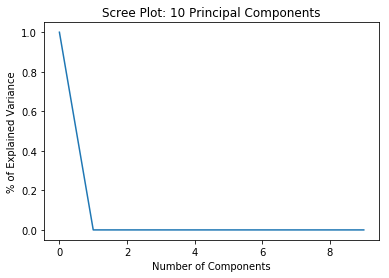

In [49]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

In [50]:
from sklearn.decomposition import FactorAnalysis

n_comp = 10

# PCA
FA = FactorAnalysis(n_components=n_comp)
FA_results_train = FA.fit_transform(train.drop(["y"], axis=1))
FA_results_test = FA.transform(test)

### Feature Engineering

Add PCA and FA components to dataset

In [51]:
print("Before feature engineering, shape is : {}".format(test_dropped.shape))

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train_dropped['pca_' + str(i)] = pca2_results_train[:,i-1]
    test_dropped['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train_dropped['fa' + str(i)] = FA_results_train[:,i-1]
    test_dropped['fa' + str(i)] = FA_results_test[:, i-1]
    
print("After feature engineering, shape is : {}".format(test_dropped.shape))

Before feature engineering, shape is : (4209, 365)
After feature engineering, shape is : (4209, 385)


***

## Machine Learning

### XGBoost
Let's try training the data on a boosted tree model. As we know, all Kagglers love XGBoost, so let's try that first.

In [52]:
## My response variables
y_train = train["y"]
## My baseline prediction: an average of the y-values
y_mean = np.mean(y_train)

# Prepare dict of params for XGBoost to run with
xgb_params = {
    ## Number of Trees
    'n_trees': 395, 
    ## Learning Rate; default = 0.3
    'eta': 0.0065,
    ## Depth of Trees
    'max_depth': 3,
    ## Bagging 50% of the training set
    'subsample': 0.50,
    'colsample_bytree': 0.75,
    'min_child_weight': 10,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    # Base Prediction = mean(target)
    'base_score': y_mean,
    'silent': 0
}

# Form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train_dropped.drop(["y"],axis=1), y_train)
dtest = xgb.DMatrix(test_dropped)

# XGBoost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=10000,
                   #nfold=10,
                   early_stopping_rounds=25,
                   verbose_eval=50, 
                   show_stdv=False,
                   seed=2017
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

## Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

## Save the model
model.save_model('models/0001.model')

[0]	train-rmse:12.6312	test-rmse:12.6263
[50]	train-rmse:10.8095	test-rmse:10.8176
[100]	train-rmse:9.69941	test-rmse:9.7224
[150]	train-rmse:9.04918	test-rmse:9.0922
[200]	train-rmse:8.68592	test-rmse:8.75613
[250]	train-rmse:8.47011	test-rmse:8.57382
[300]	train-rmse:8.33448	test-rmse:8.47368
[350]	train-rmse:8.24514	test-rmse:8.41498
[400]	train-rmse:8.18116	test-rmse:8.38353
[450]	train-rmse:8.12657	test-rmse:8.36543
[500]	train-rmse:8.08117	test-rmse:8.3553
[550]	train-rmse:8.04044	test-rmse:8.35071
[600]	train-rmse:8.00579	test-rmse:8.34853
[650]	train-rmse:7.97169	test-rmse:8.34512
649


### Grid Search

To optimize the model and tune our parameters, we can use grid search to find the best values for our parameters. To use this section, add a key/value item to the cv_params dictionary and run the chunk.

optimized_GBM will perform a grid search on the cv_param values and return the model with the parameters that performed the best in terms of r2 score.

In [31]:
## Grid Search library
from sklearn.model_selection import GridSearchCV

## Cross Validation Grid Search Params
cv_params = {'colsample_bytree': [0.50, 0.75, 0.95] }

# Prepare dict of params for XGBoost to run with
xgb_params = {
    'n_estimators': 395,
    'learning_rate': 0.0065,
    'max_depth': 3,
    'subsample': 0.50,
    'objective': 'reg:linear',
    # Base Prediction = mean(target)
    'base_score': y_mean,
    'seed': 2017,
    'silent': False
}


optimized_GBM = GridSearchCV(xgb.XGBRegressor(**xgb_params), 
                             cv_params, 
                             scoring = 'r2',
                             cv = 3,
                             n_jobs = -1,
                             verbose = 10) 

optimized_GBM.fit(train_dropped.drop(["y"],axis=1), y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.75 ...........................................
[CV] ............. colsample_bytree=0.5, score=0.494821, total=   8.4s
[CV] colsample_bytree=0.75 ...........................................
[CV] ............. colsample_bytree=0.5, score=0.574887, total=   8.4s
[CV] ............. colsample_bytree=0.5, score=0.577777, total=   8.5s
[CV] colsample_bytree=0.95 ...........................................
[CV] colsample_bytree=0.75 ...........................................


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    8.8s remaining:   17.7s


[CV] ............ colsample_bytree=0.75, score=0.501165, total=  11.9s
[CV] colsample_bytree=0.95 ...........................................


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   12.2s remaining:   15.3s


[CV] ............ colsample_bytree=0.75, score=0.577391, total=  11.2s
[CV] colsample_bytree=0.95 ...........................................


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   20.0s remaining:   16.0s


[CV] ............ colsample_bytree=0.75, score=0.575543, total=  11.3s


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   20.3s remaining:   10.2s


[CV] ............ colsample_bytree=0.95, score=0.504769, total=  13.8s


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   22.8s remaining:    6.5s


[CV] ............ colsample_bytree=0.95, score=0.576183, total=  12.6s
[CV] ............ colsample_bytree=0.95, score=0.568330, total=  10.3s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=100.669318128, colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0065, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=395,
       nthread=-1, objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=False, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': [0.5, 0.75, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [32]:
print(optimized_GBM.best_params_)
print(optimized_GBM.best_score_)

{'colsample_bytree': 0.75}
0.551366190945


In [24]:
gridSearchPredicitons = optimized_GBM.predict(test_dropped)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': gridSearchPredicitons})
output.to_csv('XGBoostGridSearch.csv', index=False)

***

### Feature Importance Plot

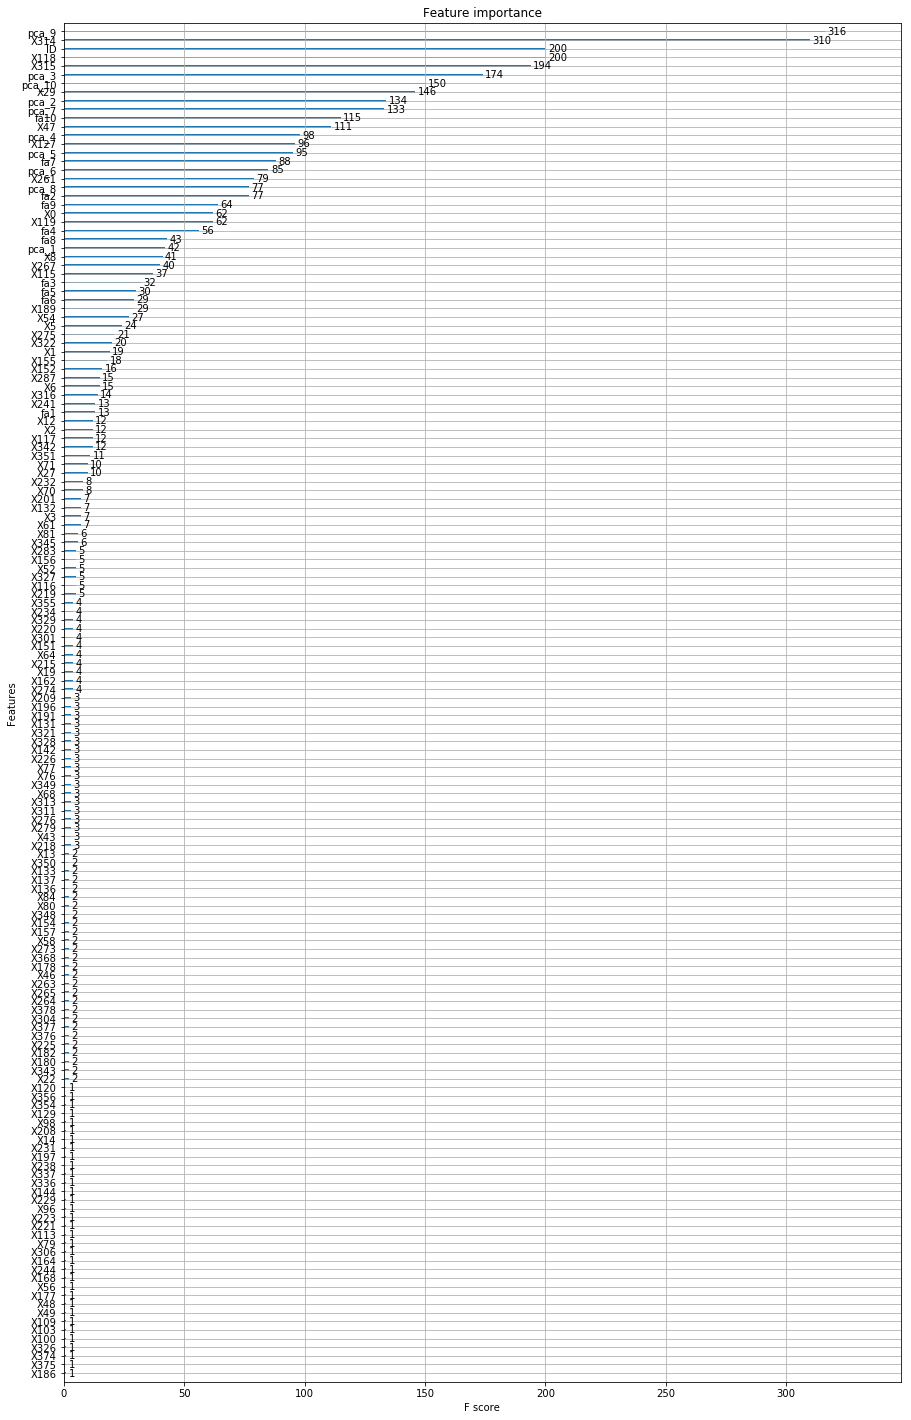

In [53]:
## Plot the feature importance plot
xgb.plot_importance(model).figure.set_size_inches( (15,25) )

In [54]:
# Check r2-score
from sklearn.metrics import r2_score

# Print out the r2-score
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.596448635489


In [55]:
# Predict on the test set and save results.
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgboost_FeatureEngineering.csv', index=False)
##output.to_csv('xgboost_700boost_395tree_2017seed_0.0065LR_3depth_50%bagging_10childweight_75%colBag.csv', index=False)

In [21]:
y_pred

array([  81.57172394,   98.27074432,   82.8078537 , ...,   93.22953796,
        110.61464691,   93.4175415 ], dtype=float32)